In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy as np
torch.set_grad_enabled(False);

!pip install onnx onnxruntime

import onnx
import onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes

        #return torch.cat((self.linear_class(h), self.linear_bbox(h).sigmoid()), dim=2)
        return self.linear_class(h).softmax(-1), self.linear_bbox(h).sigmoid()
        #return {'pred_logits': self.linear_class(h), 'pred_boxes': self.linear_bbox(h).sigmoid()}

detr_demo = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr_demo.load_state_dict(state_dict)
detr_demo.eval();

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
detr.eval()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 99.0MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cach

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [ ]:
url = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/09/13/12/surfer.jpg?w968h681'
im = Image.open(requests.get(url, stream=True).raw)

transform = T.Compose([
                        T.Resize(800),
                        T.ToTensor(),
                        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                      ])

sample_input = transform(im).unsqueeze(0)


probs, boxes = detr_demo(sample_input)

output_onnx_path = "detr_model.onnx"

torch.onnx.export(
    detr_demo,
    sample_input,
    output_onnx_path,
    opset_version=17, # Specify an appropriate ONNX opset version
    input_names=["input"],
    output_names=["logits", "boxes"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}} # Optional: for dynamic batch size
)
print(f"Model exported to {output_onnx_path}")

/usr/local/lib/python3.11/dist-packages/torch/onnx/utils.py:1824: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(


Model exported to detr_model.onnx


In [ ]:
import onnxruntime as rt
import numpy as np

sess = rt.InferenceSession(output_onnx_path)


input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# Run inference with a dummy input (convert to numpy)
onnx_output = sess.run([output_name], {input_name: sample_input.detach().cpu().numpy()})


In [ ]:

sess = rt.InferenceSession(output_onnx_path)

input_name = sess.get_inputs()[0].name
output_name = [sess.get_outputs()[0].name, sess.get_outputs()[1].name]


# Run inference with a dummy input (convert to numpy)
onnx_output = sess.run(output_name, {input_name: sample_input.detach().cpu().numpy()})

In [ ]:
example_inputs = (sample_input, )
onnx_inputs = [tensor.numpy(force=True) for tensor in example_inputs]

ort_session = onnxruntime.InferenceSession("./detr_model.onnx", providers=["CPUExecutionProvider"])

onnxruntime_input = {input_arg.name: input_value for input_arg, input_value in zip(ort_session.get_inputs(), onnx_inputs)}
# ONNX Runtime returns a list of outputs
start = time.time()
logits, boxes = ort_session.run(None, onnxruntime_input)
print(f'Inference time: {(time.time()-start):0.2f}')
probas = logits[0, :, :-1]
keep = probas.max(-1) > 0.7

Inference time: 2.64


In [ ]:
p = probas[keep].argmax(1)


for i, j in enumerate(p):
  print(f'{CLASSES[j]}: {probas[keep][i, j]:0.2f}')
  print(boxes[0, keep][i])

surfboard: 1.00
[0.4085972  0.6886709  0.40961975 0.32729325]
person: 1.00
[0.48981732 0.4383303  0.55204976 0.5079206 ]


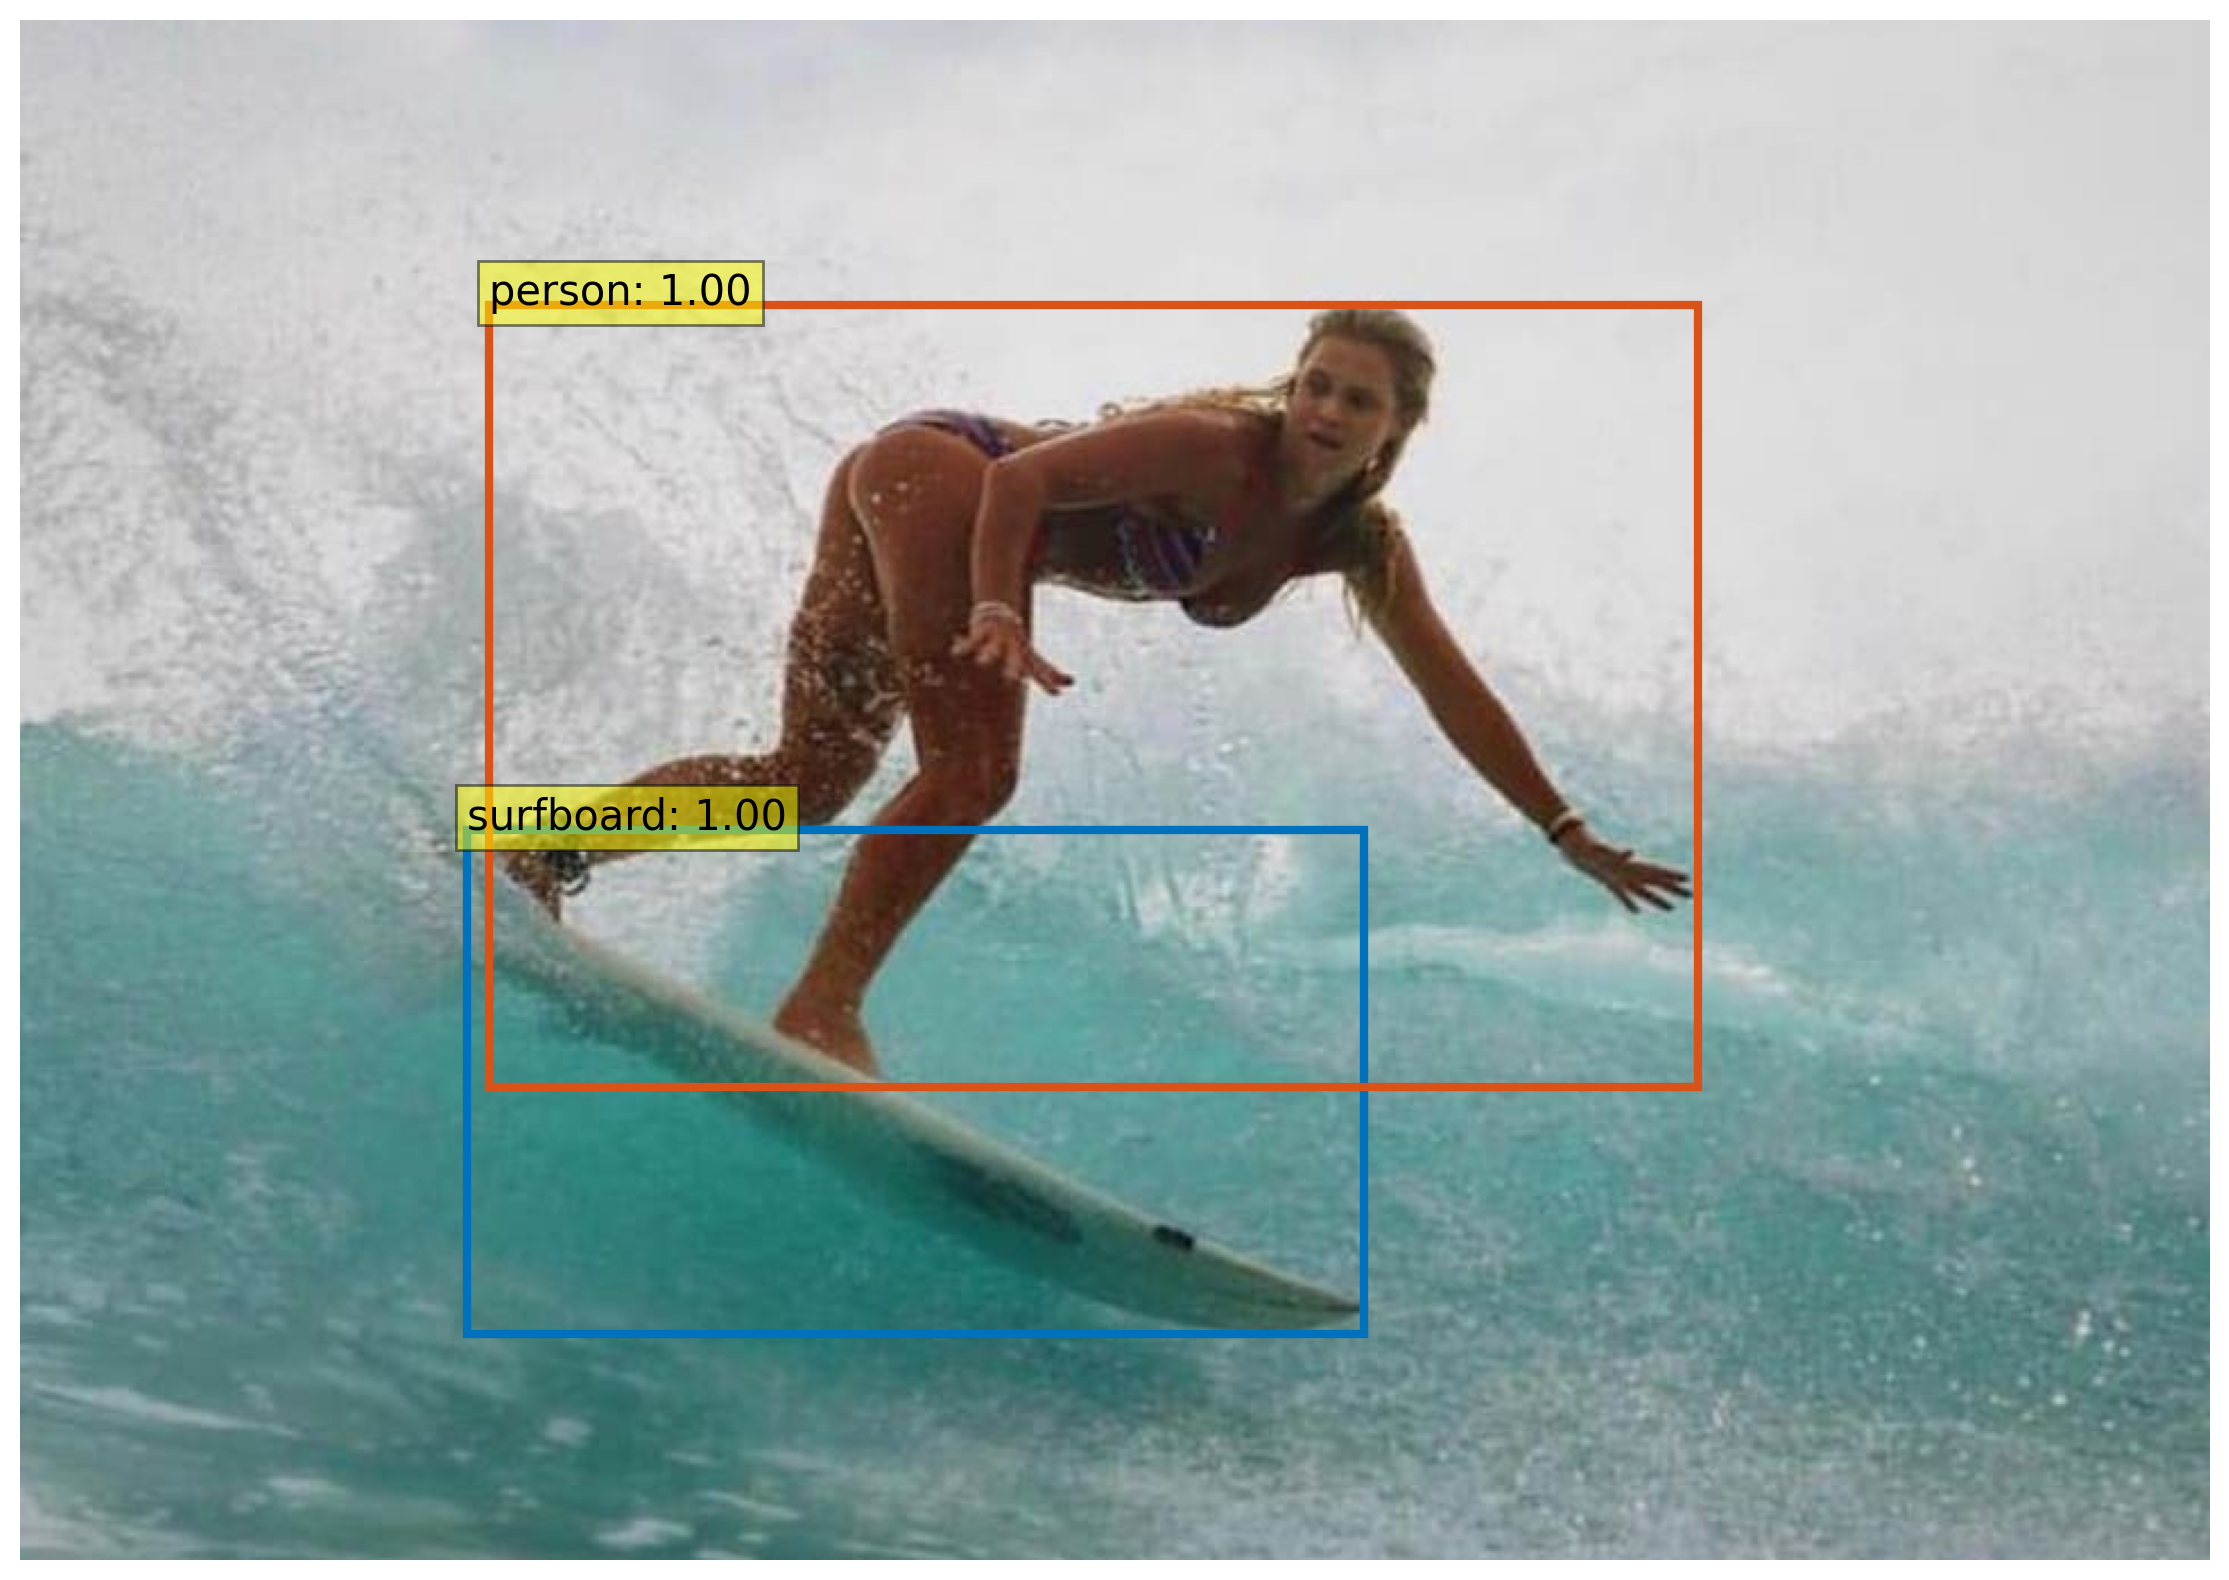

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    #x = torch.from_numpy(x)
    x_c, y_c, w, h = np.hsplit(x, 4)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return np.stack(b, axis=2)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * np.array([img_w, img_h, img_w, img_h])
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes[:, 0, :].tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


bboxes_scaled = rescale_bboxes(boxes[0, keep], im.size)
plot_results(im, probas[keep], bboxes_scaled)

In [ ]:
import time
start = time.time()
torch_logits, torch_boxes = detr_demo(sample_input)
print(time.time()-start)
probas = torch_logits[0, :, :-1]

keep = probas.max(-1).values > 0.7

p = probas[keep].argmax(1)


for i, j in enumerate(p):
  print(f'{CLASSES[j]}: {probas[keep][i, j]:0.2f}')
  print(torch_boxes[0, keep][i])

3.963472366333008
surfboard: 1.00
tensor([0.4086, 0.6887, 0.4096, 0.3273])
person: 1.00
tensor([0.4898, 0.4383, 0.5520, 0.5079])
